# Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistrated functional images with FWHM set to 4mm

## Imports

First, let's import all modules we later will be needing.

In [275]:
from os.path import join as opj
import os
import json
import nipype.interfaces.fsl as fsl
from nipype.interfaces.fsl import MCFLIRT, FLIRT
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node
from nipype.interfaces.spm import NewSegment
from nipype.interfaces.fsl import FLIRT
from nipype.interfaces.fsl import Threshold
from nipype.algorithms.confounds import TSNR
from nipype.interfaces.fsl import ApplyMask
from nipype.algorithms.misc import Gunzip
from nipype import MapNode

# Dicom to Nifti conversion

In [196]:
from nipype.interfaces.dcm2nii import Dcm2nii
converter = Dcm2nii()

# convert anatomical data
converter.inputs.gzip_output = False
converter.inputs.source_dir = './data/sub-01/anat/T1_dcm'
converter.inputs.output_dir = './data/sub-01/anat/'
converter.inputs.protocol_in_filename = False
converter.inputs.source_in_filename = False
converter.inputs.date_in_filename = False
converter.inputs.events_in_filename = False
converter.inputs.id_in_filename = True 
converter.inputs.reorient = False
converter.run() 

181203-21:56:48,656 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.655975:Chris Rorden's dcm2nii :: 4AUGUST2014 (Debian) 64bit BSD License
181203-21:56:48,657 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.655975:reading preferences file config.ini
181203-21:56:48,659 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.655975:Data will be exported to ./data/sub-01/anat/
181203-21:56:48,660 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.655975:Validating 176 potential DICOM images.
181203-21:56:48,661 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.655975:Found 176 DICOM images.
181203-21:56:48,662 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.655975:Converting 176/176  volumes: 1
181203-21:56:48,687 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.687124:PSYCH521_VISUALMOTOR.MR.BOYACI_LAB_COMMON_EXAMS.0002.0001.2018.11.27.10.49.46.171875.342669378.IMA->psych521visualMotor.nii
181203-21:56:48,688 nipype.interface INFO:
	 stdout 2018-12-03T21:56:48.687124:For 

In [197]:
# rename the ziped file according to your convention
new_file_name = './data/sub-01/anat/sub-01_T1.nii'
old_file_name = './data/sub-01/anat/psych521visualMotor.nii'
os.rename(old_file_name, new_file_name) 

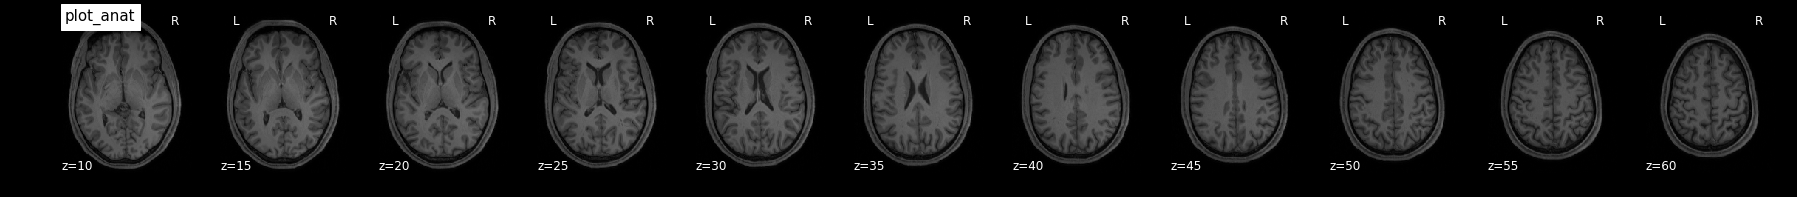

In [198]:
%matplotlib inline
from nilearn import plotting

filename = './data/sub-01/anat/sub-01_T1.nii'

plotting.plot_anat(filename,
                   display_mode='z',
                   cut_coords = (10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60),
                   title="plot_anat")

In [199]:
# convert functional runs data
run_list = ['run-01', 'run-02', 'run-03', 'run-04']
for run in run_list:
    converter = Dcm2nii()
    converter.inputs.gzip_output = False
    converter.inputs.source_dir = './data/sub-01/func/'+run+'_bold_dcm'
    converter.inputs.output_dir = './data/sub-01/func/'
    converter.inputs.protocol_in_filename = False
    converter.inputs.source_in_filename = False
    converter.inputs.date_in_filename = False
    converter.inputs.events_in_filename = False
    converter.inputs.id_in_filename = True 
    converter.run() 
    # rename the ziped file according to your convention
    new_file_name = './data/sub-01/func/sub-01_'+run+'_bold.nii'
    old_file_name = './data/sub-01/func/psych521visualMotor.nii'
    os.rename(old_file_name, new_file_name) 


181203-21:56:51,519 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.519052:Chris Rorden's dcm2nii :: 4AUGUST2014 (Debian) 64bit BSD License
181203-21:56:51,520 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.519052:reading preferences file config.ini
181203-21:56:51,521 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.519052:Data will be exported to ./data/sub-01/func/
181203-21:56:51,522 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.519052:Validating 135 potential DICOM images.
181203-21:56:51,524 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.519052:Found 135 DICOM images.
181203-21:56:51,525 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.519052:Converting 135/135  volumes: 135
181203-21:56:51,526 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.526171:PSYCH521_VISUALMOTOR.MR.BOYACI_LAB_COMMON_EXAMS.0004.0001.2018.11.27.10.49.46.171875.342673976.IMA->psych521visualMotor.nii
181203-21:56:51,527 nipype.interface INFO:
	 stdout 2018-12-03T21:56:51.526171: W

(64, 64, 30, 135)


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


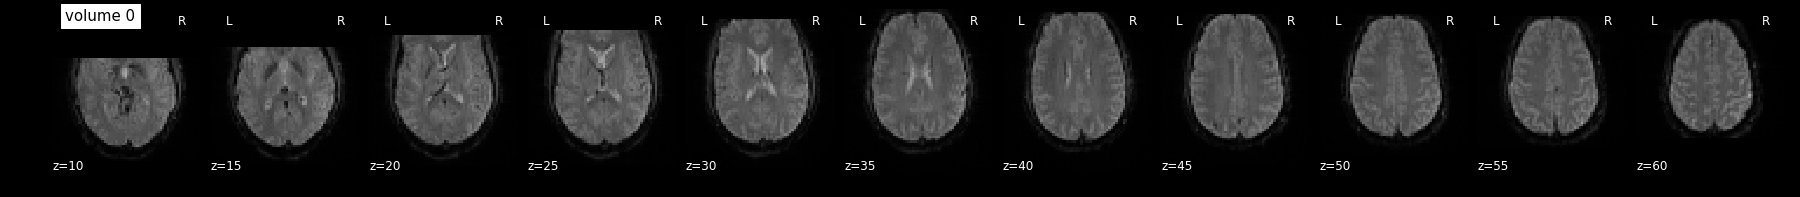

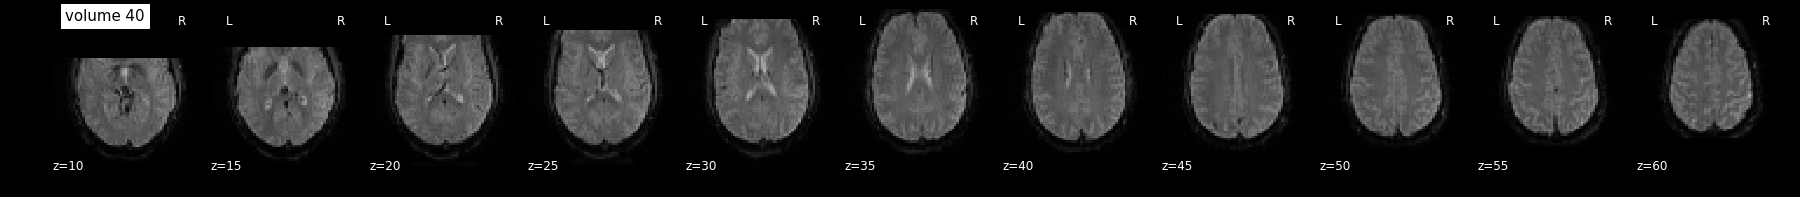

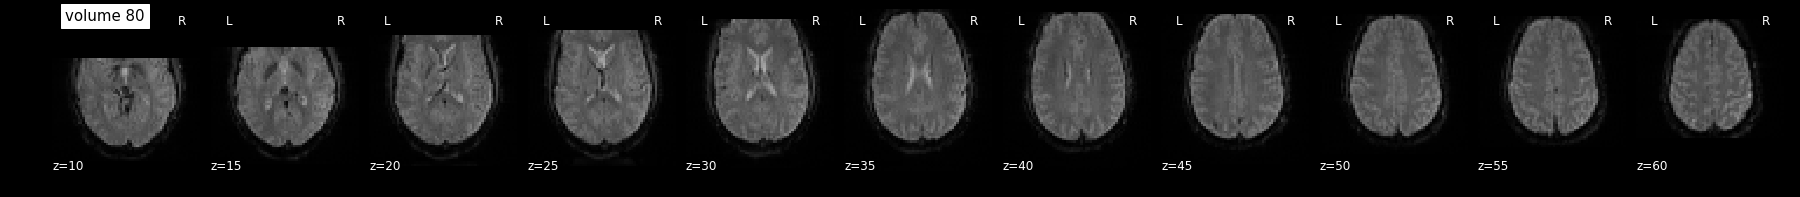

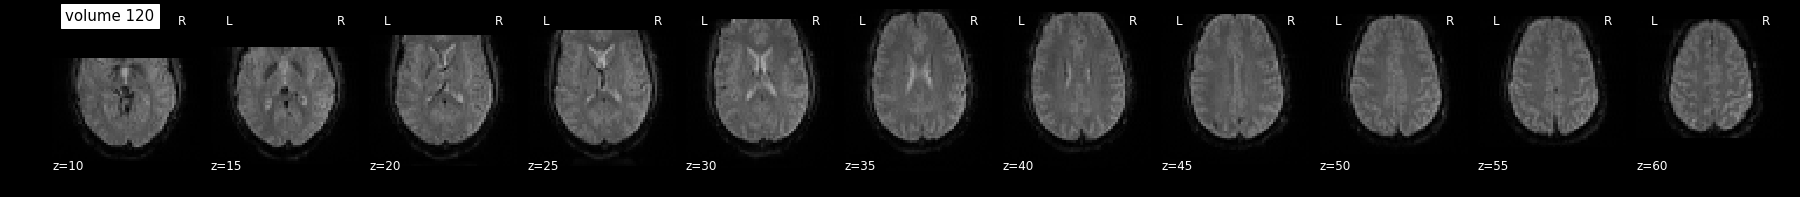

In [200]:
%matplotlib inline
from nilearn import image
from nilearn import plotting

filename = './data/sub-01/func/sub-01_run-01_bold.nii'
print(image.load_img(filename).shape)

selected_volume = image.index_img(filename, 0)

count = 0
for img in image.iter_img(filename):
    # img is now an in-memory 3D img
    
    if count%40==0:
        plotting.plot_anat(img,
                           display_mode='z',
                           cut_coords = (10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60),
                           title="volume %d"%count)
    count += 1

# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [201]:
data_dir = '/home/neuro/nipype_tutorial/data/'

experiment_dir = '/home/neuro/nipype_tutorial/output/'
output_dir = '/home/neuro/nipype_tutorial/output/datasink'
working_dir = '/home/neuro/nipype_tutorial/output/workingdir'

# list of subject identifiers
subject_list = ['sub-01']


# list of run identifiers
run_list = ['run-01', 'run-02', 'run-03', 'run-04']


# TR of functional images
TR = 2.0

# Smoothing withds used during preprocessing
fwhm = [4, 8]

In [202]:
# Use the following tissue specification to get a GM and WM probability map
tpm_img ='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]

## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [256]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

segment = Node(NewSegment(tissues=tissues), name='segment')

# FLIRT - coregister functional images to anatomical images
coreg_step1 = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")


# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'),
                name="threshold_WM")
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4

# Apply coregistration warp to functional images
coreg_step2 = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'),
                name="mask_GM")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)


mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func", 
                    iterfield=["in_file"])

detrend = Node(TSNR(regress_poly=2), name="detrend")

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [257]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'run_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('run_id', run_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('{subject_id}', 'anat', '{subject_id}_T1.nii')
func_file = opj('{subject_id}', 'func',
                '{subject_id}_{run_id}_bold.nii')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=data_dir),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [265]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

def get_gm(files):
    return files[0][0]

# Connecting the segmentation node with the threshold node
preproc.connect([])

preproc.connect([])

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('run_id', 'run_id')]),
                 (selectfiles, mcflirt, [('func', 'in_file')]),
                 (selectfiles, segment, [('anat', 'channel_files')]),
                 (segment, threshold_WM, [(('native_class_images', get_wm), 'in_file')]),
                 (threshold_WM, coreg_step1, [('out_file', 'wm_seg')]),
                 
                 (mcflirt, coreg_step1, [('mean_img', 'in_file')]),
                 (selectfiles, coreg_step1, [('anat', 'reference')]),

                 (mcflirt, coreg_step2, [('out_file', 'in_file')]),
                 (selectfiles, coreg_step2, [('anat', 'reference')]),
                 (coreg_step1, coreg_step2, [('out_matrix_file',
                                              'in_matrix_file')]),

                 (segment, resample, [(('native_class_images', get_gm), 'in_file'),
                                      (('native_class_images', get_gm), 'reference')
                                      ]),
                 (resample, mask_GM, [('out_file', 'in_file')]),
                 
                 (coreg_step2, smooth, [('out_file', 'in_files')]),
                 (smooth, mask_func, [('smoothed_files', 'in_file')]),
                 (mask_GM, mask_func, [('out_file', 'mask_file')]),
                 (mask_func, detrend, [('out_file', 'in_file')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (selectfiles, datasink, [('anat', 'preproc.@resample')]),
                 (coreg_step1, datasink, [('out_file', 'preproc.@coregmean')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (detrend, datasink, [('detrended_file', 'preproc.@detrend')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

181203-23:13:01,831 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


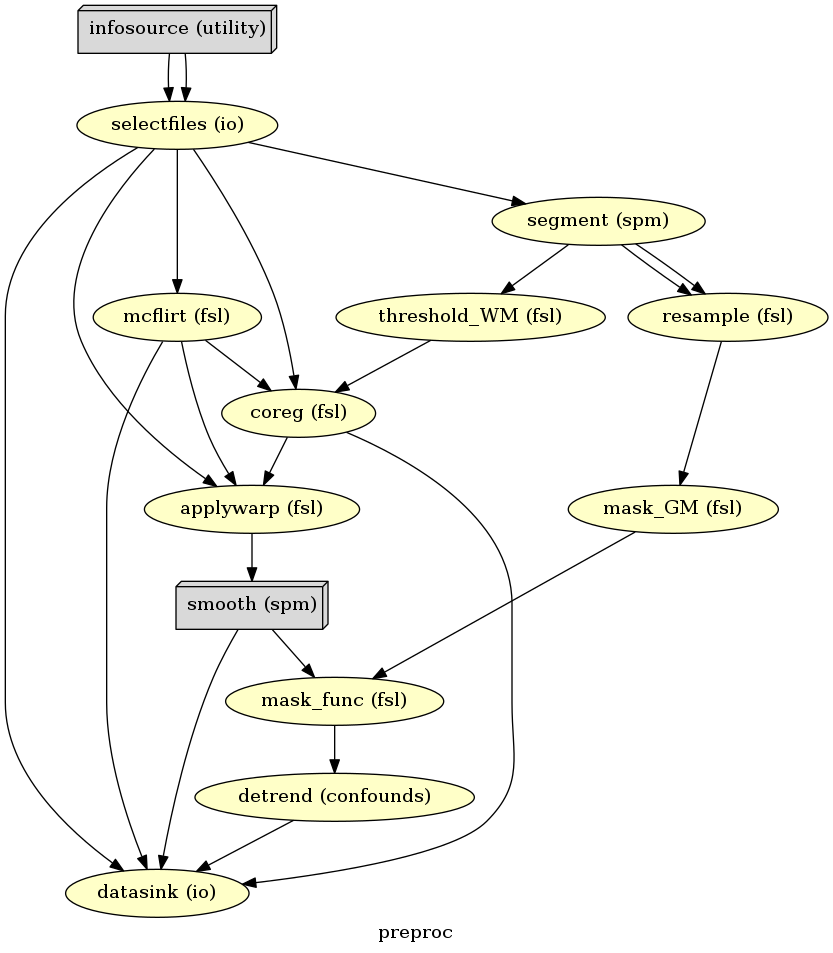

In [266]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

181203-23:13:03,637 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


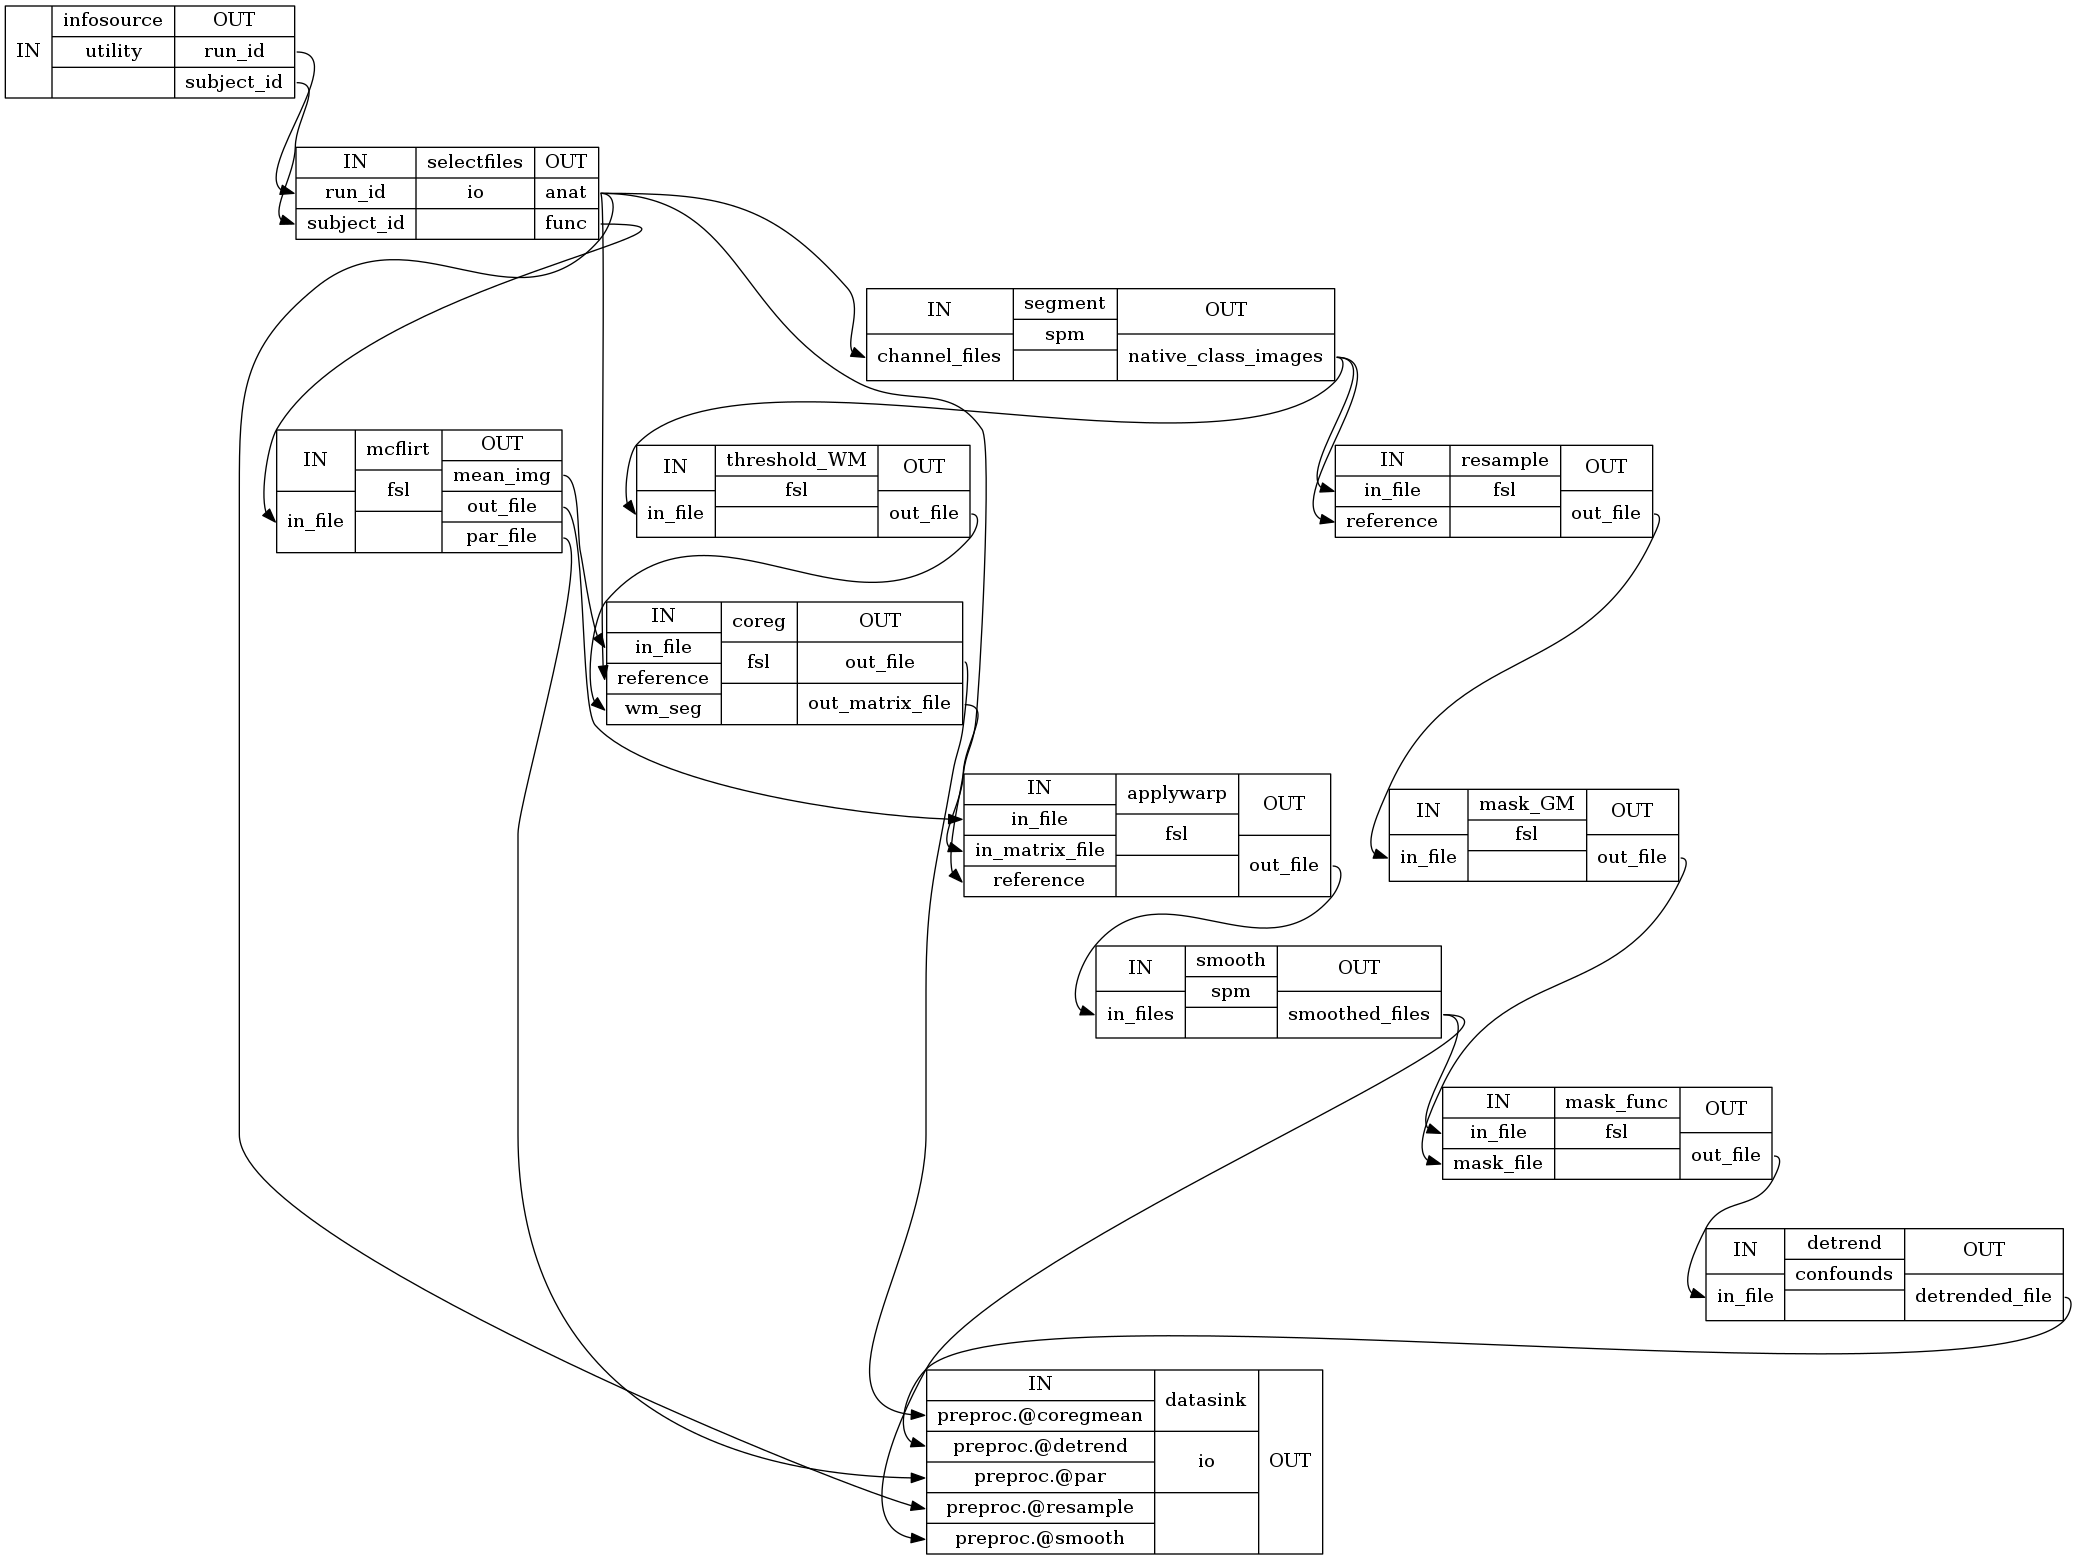

In [267]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [268]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

# !nipypecli crash /home/neuro/nipype_tutorial/crash-20181202-135706-neuro-selectfiles.b0-54a99b2b-c1f7-47e5-bde8-8f401961f66f.pklz

181203-23:13:16,481 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
181203-23:13:16,606 nipype.workflow INFO:
	 Running in parallel.
181203-23:13:16,613 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 6.97/6.97, Free processors: 4/4.
181203-23:13:16,953 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/nipype_tutorial/output/workingdir/preproc/_run_id_run-02_subject_id_sub-01/selectfiles".181203-23:13:16,954 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/nipype_tutorial/output/workingdir/preproc/_run_id_run-01_subject_id_sub-01/selectfiles".

181203-23:13:16,947 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/nipype_tutorial/output/workingdir/preproc/_run_id_run-04_subject_id_sub-01/selectfiles".
181203-23:13:16,965 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles

# Plot Motion Parameters
Now, let's investigate the motion parameters. How much did the subject move and turn in the scanner?

Text(0, 0.5, 'translation (mm)')

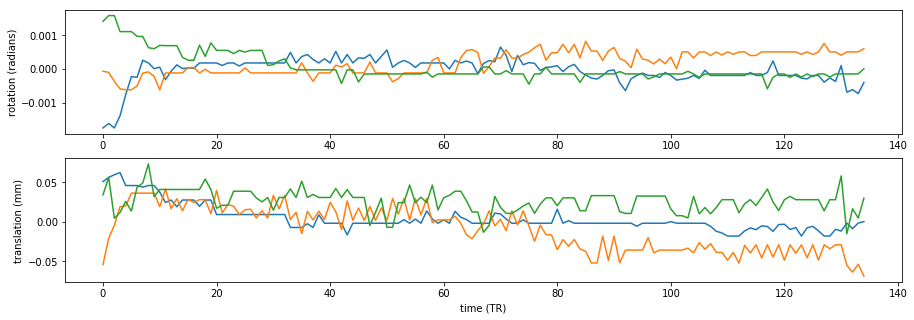

In [269]:
import numpy as np
import pylab as plt

par_file = '/home/neuro/nipype_tutorial/output/datasink/preproc/_run_id_run-03_subject_id_sub-01/sub-01_run-03_bold_mcf.nii.par'
par = np.loadtxt(par_file)

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

********************************************************************

# 1st-level Analysis using GLM

In this part we will take the preprocessed output from the first part and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

**So, let's begin!**

# Imports

First, we need to import all modules we later want to use.

In [210]:
%pylab inline
from os.path import join as opj
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'axes', 'plotting']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [211]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate.

In [234]:
# Condition names
condition_names = ['B_first', 'R', 'L', 'L-R', 'B', 'B_last']

# Contrasts
contL1= 'R > B'
contL2= 'L > B'
contL3= 'L-R > B'
contL4= 'L > B or R > B'

cont01 = [contL1,    'T', condition_names, [0, 1, 0, 0, -0.5, -0.5]]
cont02 = [contL2,    'T', condition_names, [0, 0, 1, 0, -0.5, -0.5]]
cont03 = [contL2,    'T', condition_names, [0, 0, 0, 1, -0.5, -0.5]]

cont04 = [contL4,    'F', [cont01, cont02]]

contrast_list = [cont01, cont02, cont03, cont04]

# Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for first run for subject 1:

In [235]:
!cat {data_dir}sub-01/func/{subject_list[0]}_{run_list[0]}_event.tsv

onset	duration	stimulus
0	10	'B_first'
10	6	'R'
16	6	'L'
22	6	'L-R'
28	6	'B'
34	6	'R'
40	6	'L'
46	6	'L-R'
52	6	'B'
58	6	'R'
64	6	'L'
70	6	'L-R'
76	6	'B'
82	6	'R'
88	6	'L'
94	6	'L-R'
100	6	'B'
106	6	'R'
112	6	'L'
118	6	'L-R'
124	11	'B_last'


So what we need is the onset and the stimuli type, i.e. **column 0** and **column 2**.

Now, let us incorporate all this information in the helper function subjectinfo to get the GLM model.

**Note that since the helper function will be defined as a node, all imports and variables should be redefined.**

In [236]:
def subjectinfo(subject_id, run_id):

    import numpy as np
    import json
    from os.path import join as opj
    from nipype.interfaces.base import Bunch
    
    data_dir = '/home/neuro/nipype_tutorial/data/'
    
    
    condition_names = ['B_first', 'R', 'L', 'L-R', 'B', 'B_last']
    

    logfile_dir = opj(data_dir, subject_id, 'func')

    # Read the TSV file
    filename = opj(logfile_dir,
                   '%s_%s_event.tsv' % (subject_id, run_id))

    # Save relevant information
    trailinfo = np.genfromtxt(filename, delimiter='\t',
                              dtype=None, skip_header=1)
    trailinfo = [[t[0], t[2]] for t in trailinfo]

    # Separate onset of conditions
    onset1 = []
    onset2 = []
    onset3 = []
    onset4 = []
    onset5 = []
    onset6 = []


    for t in trailinfo:
        condition = t[1]
        onset = t[0]*2
        if b"'B_first'" == condition:
            onset1.append(onset)
            
        if b"'R'" == condition:
            onset2.append(onset)
            
        if b"'L'" == condition:
            onset3.append(onset)
            
        if b"'L-R'" == condition:
            onset4.append(onset)
            
        if b"'B'" == condition:
            onset5.append(onset)
            
        if b"'B_last'" == condition:
            onset6.append(onset)


    subjectinfo = [Bunch(conditions=condition_names,
                         onsets=[onset1, onset2, onset3, onset4, onset5, onset6],
                         durations=[[20.0], [12.0], [12.0], [12.0], [12.0], [22.0]],
                         amplitudes=None,
                         tmod=None,
                         pmod=None,
                         regressor_names=None,
                         regressors=None)]


    return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id', 'run_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [237]:
subjectinfo('sub-01', 'run-02')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


[Bunch(amplitudes=None,
       conditions=['B_first', 'R', 'L', 'L-R', 'B', 'B_last'],
       durations=[[20.0], [12.0], [12.0], [12.0], [12.0], [22.0]],
       onsets=[[0],
        [20, 68, 116, 164, 212],
        [32, 80, 128, 176, 224],
        [44, 92, 140, 188, 236],
        [56, 104, 152, 200],
        [248]],
       pmod=None,
       regressor_names=None,
       regressors=None,
       tmod=None)]

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [277]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'run_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('run_id', run_list),
                        ('fwhm_id', fwhm)]

gunzip_func = Node(Gunzip(), name='gunzip_func')

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '_run_id_{run_id}_subject_id_{subject_id}',
                         '_fwhm_{fwhm_id}', 'detrend.nii.gz'),
# # Here the unpreprocessed data is used for GLM analyis
# template = {'func': opj(data_dir, '{subject_id}', 'func',
#                 '{subject_id}_{run_id}_bold.nii'),             
             'mc_param': opj(output_dir, 'preproc', '_run_id_{run_id}_subject_id_{subject_id}',
                             '{subject_id}_{run_id}_bold_mcf.nii.par')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [278]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('run_id', 'run_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id', 'subject_id'),
                                                 ('run_id', 'run_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    
                    (selectfiles, gunzip_func, [('func', 'in_file')]),
                    (gunzip_func, modelspec, [('out_file', 'functional_runs')]),
                    
                    (selectfiles, modelspec, [('mc_param',
                                               'realignment_parameters')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

181203-23:26:50,273 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


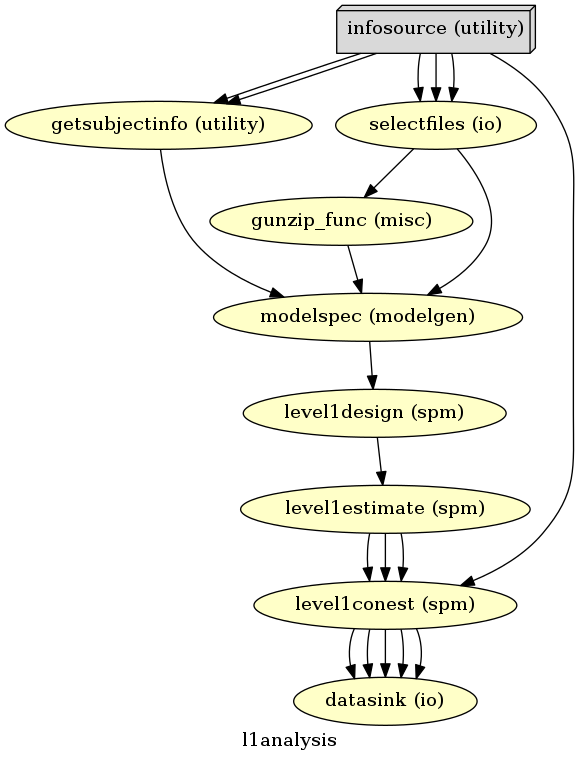

In [279]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

181203-23:26:51,358 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir/l1analysis/graph.png (graph2use=flat, simple_form=True).


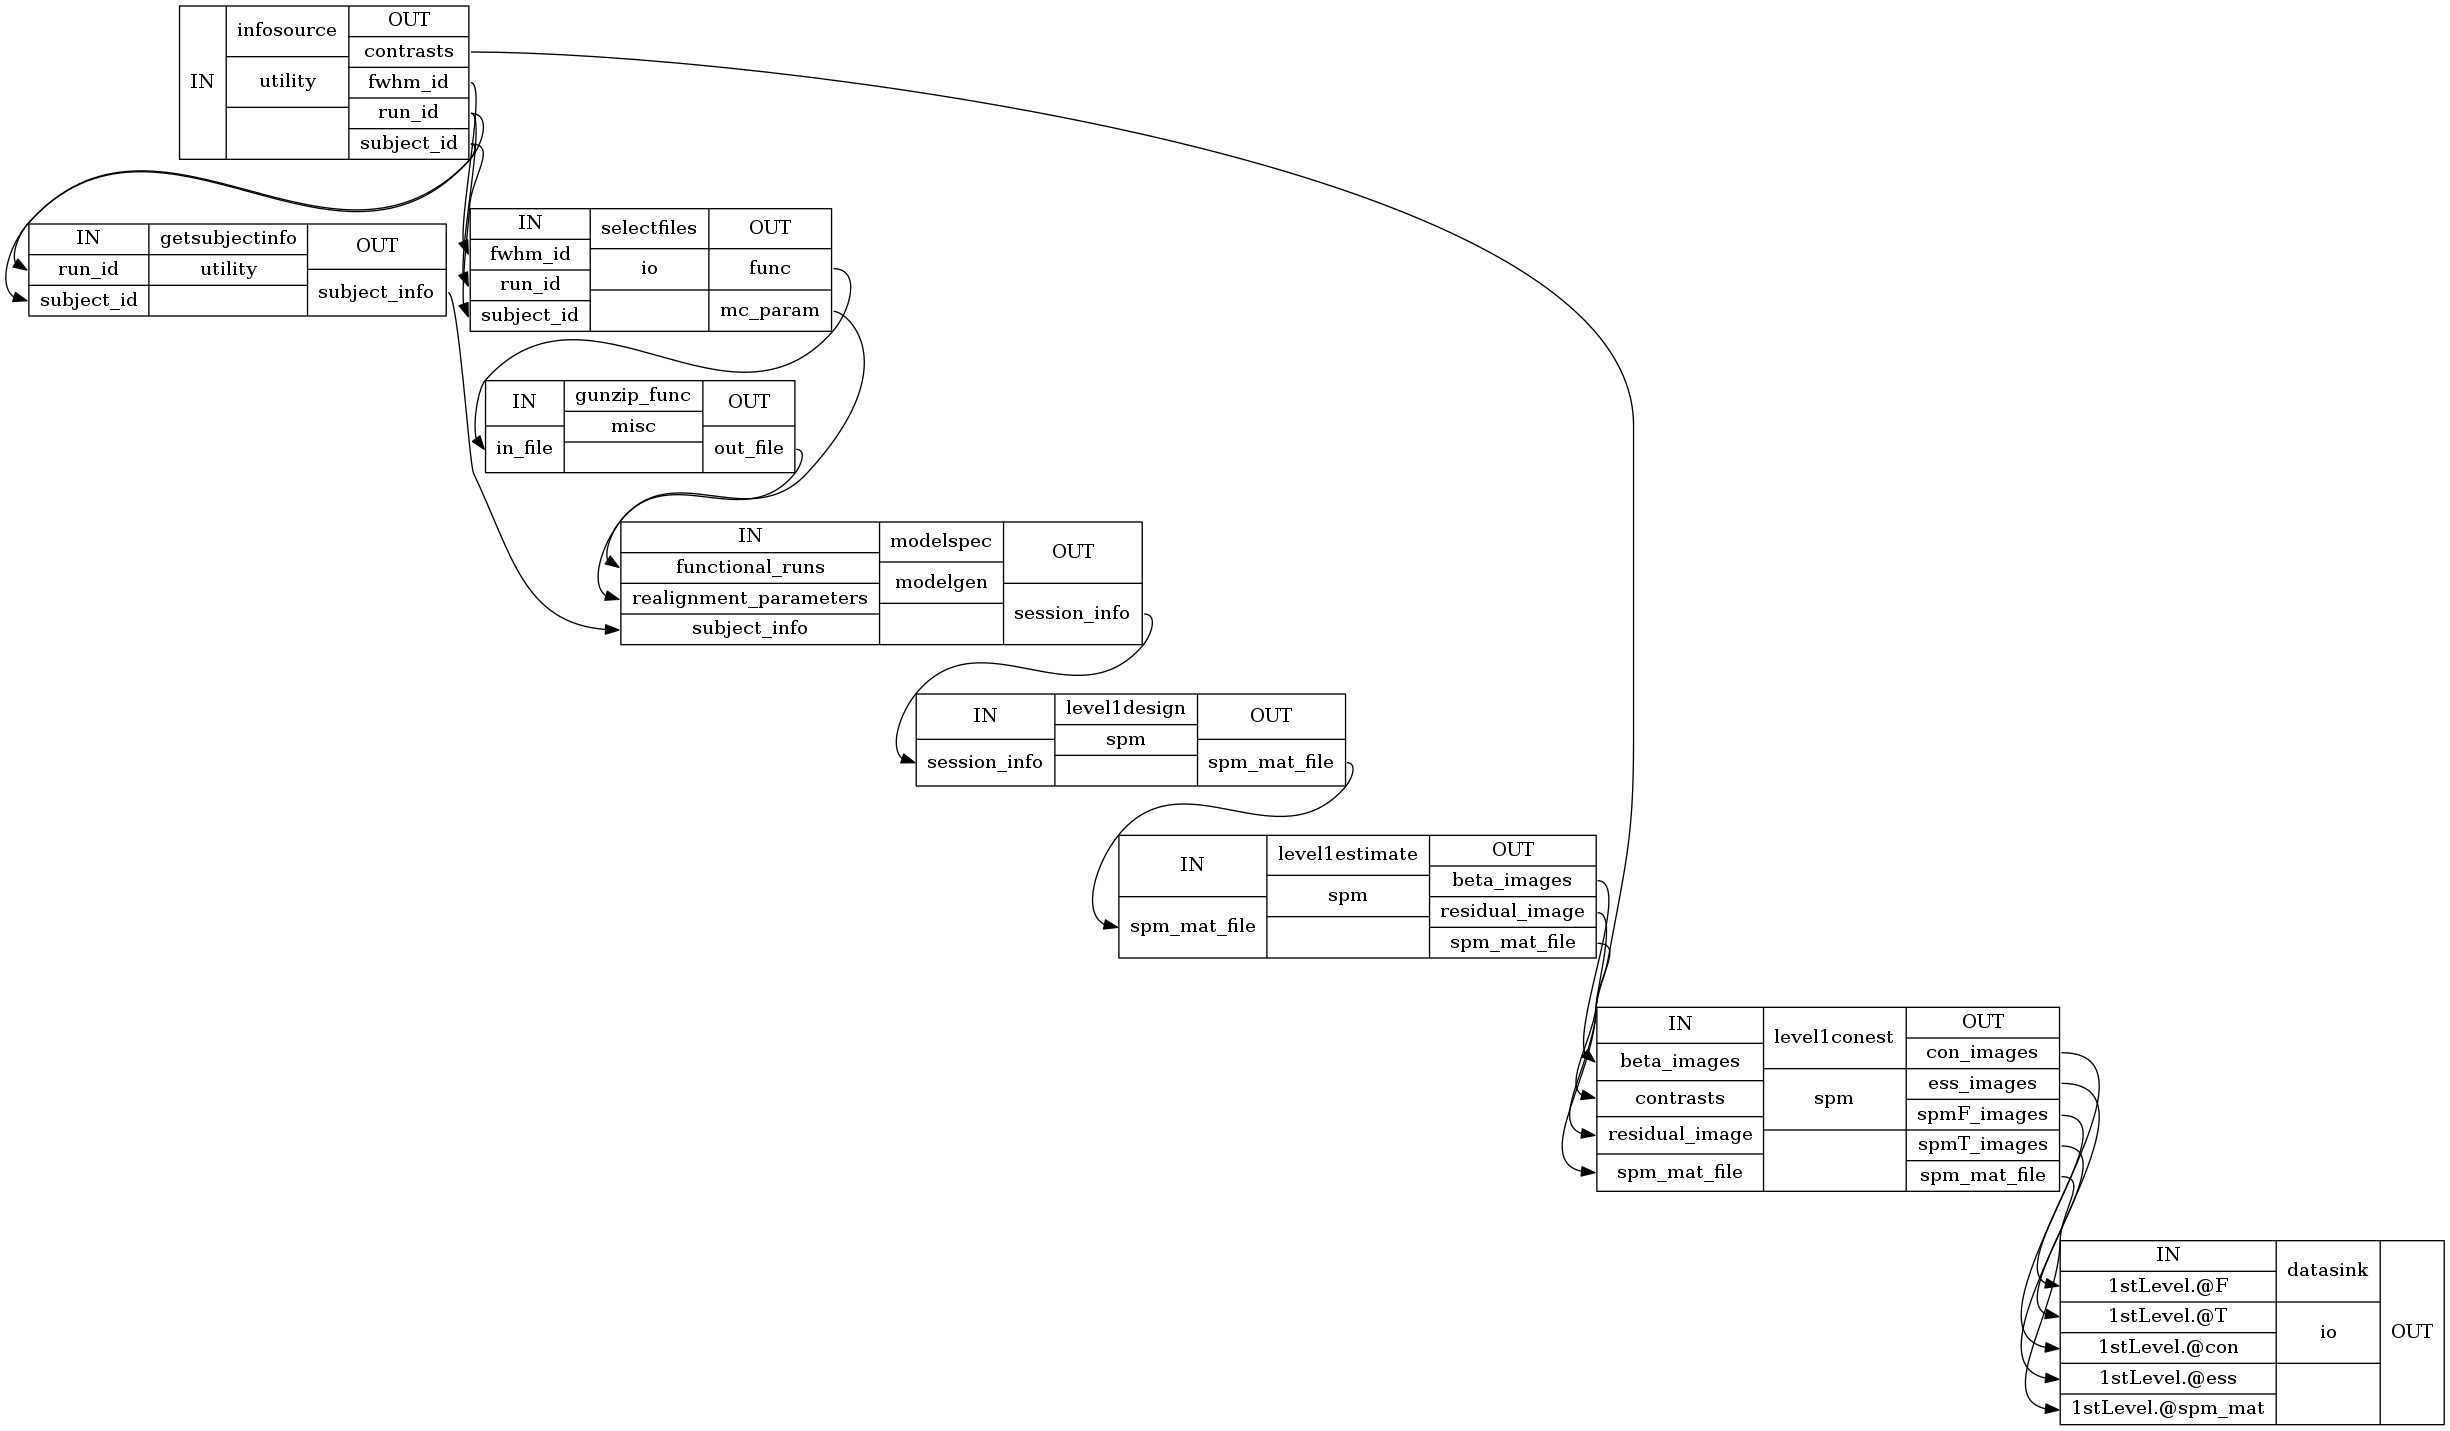

In [280]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph_detailed.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [281]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

# !nipypecli crash /home/neuro/nipype_tutorial/crash-20171203-084943-neuro-getsubjectinfo.a0-ff371092-d758-40cb-a8ea-546235f16065.pklz

181203-23:27:04,634 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
181203-23:27:04,741 nipype.workflow INFO:
	 Running in parallel.
181203-23:27:04,747 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 16 jobs ready. Free memory (GB): 6.97/6.97, Free processors: 4/4.
181203-23:27:05,25 nipype.workflow INFO:
	 [Job 0] Cached (l1analysis.getsubjectinfo).
181203-23:27:05,87 nipype.workflow INFO:
	 [Job 8] Cached (l1analysis.getsubjectinfo).
181203-23:27:05,95 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/nipype_tutorial/output/workingdir/l1analysis/_fwhm_id_8_run_id_run-04_subject_id_sub-01/selectfiles".181203-23:27:05,98 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/nipype_tutorial/output/workingdir/l1analysis/_fwhm_id_4_run_id_run-04_subject_id_sub-01/selectfiles".

181203-23:27:05,129 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interf

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [243]:
!tree {output_dir}/1stLevel

/home/neuro/nipype_tutorial/output/datasink/1stLevel
├── _fwhm_id_4_run_id_run-01sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── ess_0004.nii
│   ├── spmF_0004.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   └── spmT_0003.nii
├── _fwhm_id_4_run_id_run-02sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── ess_0004.nii
│   ├── spmF_0004.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   └── spmT_0003.nii
├── _fwhm_id_4_run_id_run-03sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── ess_0004.nii
│   ├── spmF_0004.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   └── spmT_0003.nii
├── _fwhm_id_4_run_id_run-04sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── ess_0004.nii
│   ├── spmF_0004.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   └── spmT_0003.nii
├── _fwhm_id_8_run_id_run-01sub-01
│   ├── con_0001.nii

# Visualize results

Let's look at the contrasts of one subject that we've just computed using the anatomical coregistration.

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


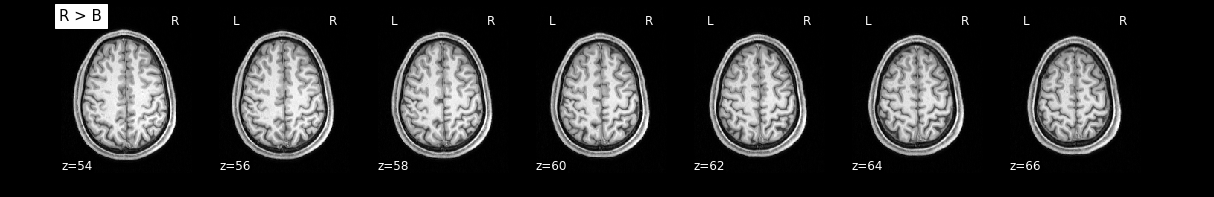

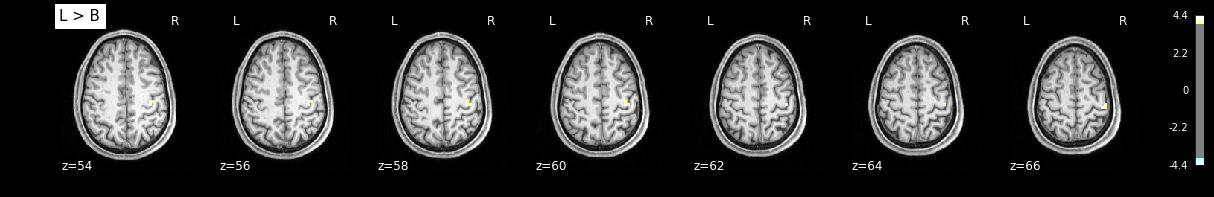

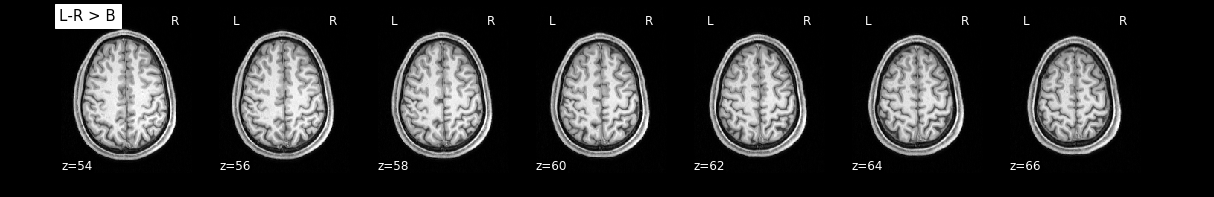

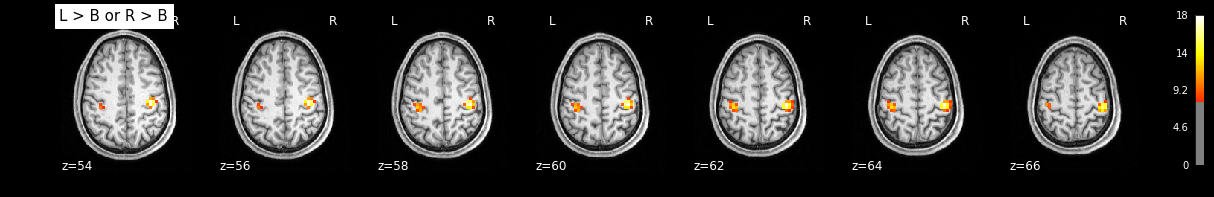

In [295]:
from nilearn.plotting import plot_stat_map
anatimg = data_dir+'sub-01/anat/sub-01_T1.nii'
# cut_coords=(-14,-12,-10,-8,-6,-4,-2)
cut_coords=(54,56,58,60,62,64,66)
threshold = 4.0


contrasts_dir = output_dir + '/1stLevel/_fwhm_id_8_run_id_run-04sub-01'
plot_stat_map(
    contrasts_dir+'/spmT_0001.nii', title=contL1,
    bg_img=anatimg, threshold=threshold, display_mode='z', cut_coords=cut_coords, dim=-1)

plot_stat_map(
    contrasts_dir+'/spmT_0002.nii', title=contL2,
    bg_img=anatimg, threshold=threshold, display_mode='z', cut_coords=cut_coords, dim=-1)

plot_stat_map(
    contrasts_dir+'/spmT_0003.nii', title=contL3,
    bg_img=anatimg, threshold=threshold, display_mode='z', cut_coords=cut_coords, dim=-1)


plot_stat_map(
    contrasts_dir+'/spmF_0004.nii', title=contL4,
    bg_img=anatimg, threshold=2*threshold, display_mode='z', cut_coords=cut_coords, dim=-1)

(64, 64, 30, 135)


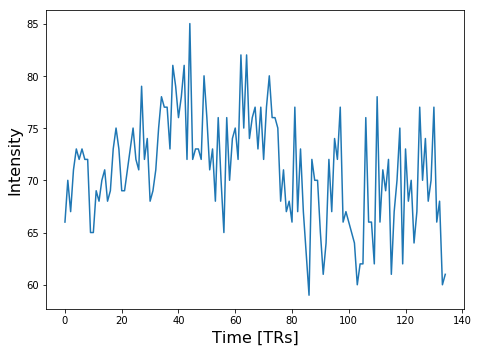

In [287]:
import matplotlib.pyplot as plt
from nibabel.testing import data_path
import nibabel as nib

filename = opj(data_dir, 'sub-01', 'func', 'sub-01_run-01_bold.nii')
img = nib.load(filename)
print(img.shape)

plt.figure(figsize=(7, 5))
plt.plot(img.dataobj[15, 15, 15, :])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
# plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

show()